# Volatility Capital Trading Strategy

In [386]:
# If you want to make the cells wider, run this
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



In [382]:
# importing libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy as sp
from scipy.interpolate import interp1d

import seaborn as sns

from datetime import datetime


import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

from plotnine import *
from plotnine.data import *

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# import pandas_datareader
import quandl
import pickle

import functools
import datetime as dt
from datetime import datetime, timedelta
import warnings

import plotly.express as px
# import kaleido

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import arch
from sklearn.linear_model import LinearRegression

# configuring
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 65
pd.set_option('use_inf_as_na', True)

sns.set()
color = sns.color_palette()
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

def plot_cones(cone_data, interp_cone_data, ticker, w):
    """
    cone_data: df that contains cone boundary points
    interp_cone_data: df that contains interpolated cone boundary points
    ticker: ticker whose cone data is being plotted
    w: weighting used to build cones {mean, exponential}
    """
    palette = sns.color_palette("flare", 10)
    my_cmap = ListedColormap(palette.as_hex())
    
    fig, ax = plt.subplots()

    ax.scatter(cone_data['days_to_expiry'], cone_data['cone'], c=cone_data['rank'], 
               cmap = my_cmap, alpha=1)

    for rank in range(1,11):
        x = [i for i in range(10,92)]
        y = interp_cone_data[interp_cone_data['rank'] == rank]['interp_cone'].to_list()
        ax.plot(x, y, c=palette[rank-1], alpha=0.7, label=f'Rank {rank}')

    ax.legend()
    plt.title(f'Volatility Cones - Ticker: {ticker}, Weighting: {w}')   
    plt.xlabel('Days to Expiry')
    plt.ylabel('Volatility Splines')
    plt.legend()
    plt.show()
    
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [3]:
# Import Cones Data

cones_data_groups = {}
cones_data_groups["AMD_interp_exp_cones"] = AMD_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AMD_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["AMD_interp_mean_cones"] = AMD_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AMD_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["AMD_realized_exp_cones"] = AMD_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AMD_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["AMD_realized_mean_cones"] = AMD_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AMD_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["AVGO_interp_exp_cones"] = AVGO_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AVGO_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["AVGO_interp_mean_cones"] = AVGO_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AVGO_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["AVGO_realized_exp_cones"] = AVGO_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AVGO_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["AVGO_realized_mean_cones"] = AVGO_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/AVGO_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["INTC_interp_exp_cones"] = INTC_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/INTC_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["INTC_interp_mean_cones"] = INTC_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/INTC_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["INTC_realized_exp_cones"] = INTC_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/INTC_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["INTC_realized_mean_cones"] = INTC_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/INTC_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["MCHP_interp_exp_cones"] = MCHP_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MCHP_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["MCHP_interp_mean_cones"] = MCHP_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MCHP_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["MCHP_realized_exp_cones"] = MCHP_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MCHP_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["MCHP_realized_mean_cones"] = MCHP_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MCHP_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["MPWR_interp_exp_cones"] = MPWR_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MPWR_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["MPWR_interp_mean_cones"] = MPWR_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MPWR_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["MPWR_realized_exp_cones"] = MPWR_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MPWR_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["MPWR_realized_mean_cones"] = MPWR_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MPWR_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["MU_interp_exp_cones"] = MU_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MU_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["MU_interp_mean_cones"] = MU_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MU_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["MU_realized_exp_cones"] = MU_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MU_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["MU_realized_mean_cones"] = MU_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/MU_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["NVDA_interp_exp_cones"] = NVDA_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NVDA_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["NVDA_interp_mean_cones"] = NVDA_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NVDA_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["NVDA_realized_exp_cones"] = NVDA_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NVDA_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["NVDA_realized_mean_cones"] = NVDA_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NVDA_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["NXPI_interp_exp_cones"] = NXPI_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NXPI_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["NXPI_interp_mean_cones"] = NXPI_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NXPI_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["NXPI_realized_exp_cones"] = NXPI_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NXPI_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["NXPI_realized_mean_cones"] = NXPI_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/NXPI_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["QCOM_interp_exp_cones"] = QCOM_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/QCOM_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["QCOM_interp_mean_cones"] = QCOM_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/QCOM_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["QCOM_realized_exp_cones"] = QCOM_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/QCOM_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["QCOM_realized_mean_cones"] = QCOM_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/QCOM_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["SWKS_interp_exp_cones"] = SWKS_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/SWKS_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["SWKS_interp_mean_cones"] = SWKS_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/SWKS_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["SWKS_realized_exp_cones"] = SWKS_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/SWKS_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["SWKS_realized_mean_cones"] = SWKS_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/SWKS_realized_mean_cones.csv").iloc[: , 1:]
cones_data_groups["TXN_interp_exp_cones"] = TXN_interp_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/TXN_interp_exp_cones.csv").iloc[: , 1:]
cones_data_groups["TXN_interp_mean_cones"] = TXN_interp_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/TXN_interp_mean_cones.csv").iloc[: , 1:]
cones_data_groups["TXN_realized_exp_cones"] = TXN_realized_exp_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/TXN_realized_exp_cones.csv").iloc[: , 1:]
cones_data_groups["TXN_realized_mean_cones"] = TXN_realized_mean_cones = pd.read_csv("/Users/williamsammartino/Desktop/all_cone_data/TXN_realized_mean_cones.csv").iloc[: , 1:]


In [355]:
# Get Fama French factor returns
fama_french = pd.read_csv("/Users/williamsammartino/Desktop/F-F_Research_Data_Factors.CSV",\
                         header = 2)

# Needs to be formated
fama_french.rename(columns={ fama_french.columns[0]: "date" }, inplace = True)

fama_french = fama_french.iloc[1000:1145,]

fama_french["year"] = pd.to_numeric(fama_french.iloc[:, 0].str[:4])
fama_french["month"] = pd.to_numeric(fama_french.iloc[:, 0].str[4:7])

fama_french["Mkt-RF"] = pd.to_numeric(fama_french["Mkt-RF"]) / 100
fama_french["SMB"] = pd.to_numeric(fama_french["SMB"]) / 100
fama_french["HML"] = pd.to_numeric(fama_french["HML"]) / 100
fama_french["RF"] = pd.to_numeric(fama_french["RF"]) / 100

fama_french.set_index(['year', 'month'], inplace = True)

In [4]:
# Import realized volatility forecasts
pred_realized_vol = pd.read_csv("/Users/williamsammartino/Desktop/backtest_pred_realized_vol.csv")
pred_realized_vol["date"] = pred_realized_vol["date"].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

# Import options data 
options_data = pd.read_csv("/Users/williamsammartino/Desktop/options_prices_microchips.csv")

In [5]:
# Import stock price data (underlyings)
stock = pd.read_csv("/Users/williamsammartino/Desktop/microchip_stocks.csv")

In [6]:
stock["date_raw"] = stock["date"]
stock["date"] = stock["date"].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [25]:
options_data["date_raw"] = options_data["date"]
# options_data["date"] = options_data["date"].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
options_data["date"] = pd.to_datetime(options_data["date_raw"].astype("str"))
# options_data["expiry_date"] = options_data["exdate"].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
options_data["expiry_date"] = pd.to_datetime(options_data["exdate"].astype("str"))
options_data = options_data[options_data["date"]>="2017-12-01"]
options_data["strike"] = options_data["strike_price"] / 1000 

In [26]:
options_data_groups = {}
groups = ["AMD", "AVGO", "INTC", "MCHP", "MPWR", "MU", "NVDA", "NXPI", "QCOM", "SWKS", "TXN"]
for grp in groups:
    options_data_groups[grp] = options_data[options_data["ticker"] == grp].copy()

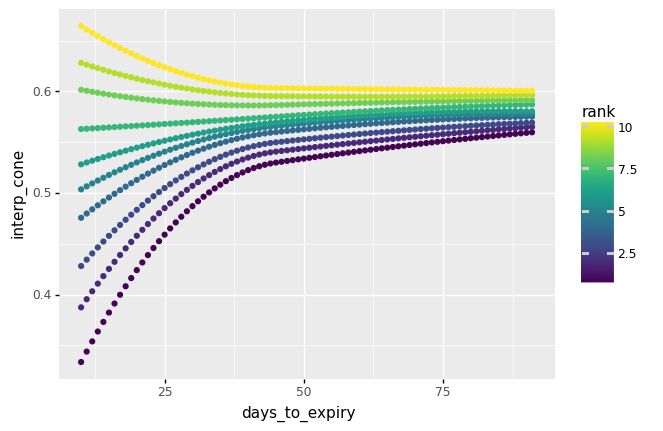

<ggplot: (711103341)>

In [27]:
(ggplot(data = cones_data_groups["AMD_interp_mean_cones"], mapping= aes(x = "days_to_expiry", y = "interp_cone", color = "rank")) +
geom_point())

In [275]:
options_data_groups["AMD"][['best_offer', 'best_bid']]

,best_offer,best_bid
3761490,0.73,0.71
3761491,0.23,0.21
3761492,0.01,0.00
3761493,0.01,0.00
3761494,0.01,0.00
...,...,...
10452460,22.20,20.35
10452461,25.75,21.60
10452462,27.40,23.20
10452463,28.80,25.00


In [387]:
# Functions for strategy ###########################################################
####################################################################################

# THIS FUNCTION GETS OPTION CANDIDATES FOR EACH STOCK

stock_of_interest = "AMD"
cone_type = "_interp_mean_cones"
date_of_interest = "2018-1-10"
days_ahead_forecast = 10
high_rank = 6
low_rank = 4

def get_candidates(stock_of_interest, date_of_interest, days_ahead_forecast, cone_type, high_rank, low_rank) :
    
    # Get spot stock price
    spot_stock_price = stock[(stock["TICKER"] == stock_of_interest) & 
                 (stock["date"] == date_of_interest)]["PRC"].values
    
    # Get spot IV of ATM options
    ############################################
    options_table = options_data_groups[stock_of_interest]
    options_table["days_to_expiry"] = (options_table["expiry_date"] - dt.datetime.strptime(date_of_interest, '%Y-%m-%d')).dt.days
    options_table = options_table[options_data["date"] == date_of_interest]
    options_table["moneyness"] = abs(options_table["strike"] - spot_stock_price)
    options_table = options_table[options_table["moneyness"] == options_table["moneyness"].min()][['ticker', 'optionid','cp_flag','days_to_expiry', 'strike', 'best_bid', 'best_offer', 'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta']]
    options_table = options_table[options_table["days_to_expiry"] > (days_ahead_forecast + 1)] # Options need to have enough time left for forecast.
    
    
    # Join to Cone to make comparison
    cones_table = cones_data_groups[stock_of_interest + cone_type]
    options_table = options_table.merge(cones_table[(cones_table["rank"] == high_rank) | (cones_table["rank"] == low_rank)],\
                        on='days_to_expiry', how='left').dropna()
    
    
    options_table["oob"] = np.where(
        ((options_table["rank"] == low_rank) & \
        (options_table["impl_volatility"] < options_table["interp_cone"])) | 
        ((options_table["rank"] == high_rank) & \
        (options_table["impl_volatility"] > options_table["interp_cone"])), True, False)
    
    options_table = options_table[options_table["oob"] == True]
    
    # Check Forecast 
    sell_dates = []
    forecast = np.empty(len(options_table))
    forecast_time = np.empty(len(options_table))
    gap_tolerance = 10
    for i in range(0, len(options_table)):
        reference_real_vol_time = min([10, 30, 60, 91], key=lambda x:abs(x-(options_table["days_to_expiry"].iloc[i] - days_ahead_forecast))) # Gets vol time of whatever is left of the option in the future.
        reference_real_vol = pred_realized_vol[pred_realized_vol["date"] ==
                      max(date for date in safe_dates["date"] if date <= (dt.datetime.strptime(date_of_interest, '%Y-%m-%d') + dt.timedelta(days=days_ahead_forecast)))][str(reference_real_vol_time) + "_" + stock_of_interest]
        sell_date = max(date for date in safe_dates["date"] if date <= (dt.datetime.strptime(date_of_interest, '%Y-%m-%d') + dt.timedelta(days=days_ahead_forecast)))
        gap = abs(reference_real_vol_time - (options_table["days_to_expiry"].iloc[i] - days_ahead_forecast))
        
        cone_upper_bound = cones_table[(cones_table["days_to_expiry"] == reference_real_vol_time) & (cones_table["rank"] == high_rank)]["interp_cone"]
        cone_lower_bound = cones_table[(cones_table["days_to_expiry"] == reference_real_vol_time) & (cones_table["rank"] == low_rank)]["interp_cone"]
        
        if (gap <= gap_tolerance) & (options_table["rank"].iloc[i] == high_rank) & (float(reference_real_vol) < float(cone_upper_bound)):
                forecast_time[i] = reference_real_vol_time
                forecast[i] = reference_real_vol
                sell_dates.append(sell_date)
        elif (gap <= gap_tolerance) & (options_table["rank"].iloc[i] == low_rank) & (float(reference_real_vol) > float(cone_lower_bound)):
                forecast_time[i] = reference_real_vol_time
                forecast[i] = reference_real_vol
                sell_dates.append(sell_date)
        else:
            forecast_time[i] = float('nan')
            forecast[i] = float('nan')
            sell_dates.append(np.nan)
    
    options_table["sell_date"] = np.array(sell_dates)
    options_table["forecast_days_to_expiry"] = forecast_time
    options_table["forecast"] = forecast
    
    options_table = options_table.dropna()
    
    # Calculate PnL estimate for each option
    options_table["pnl_estimate"] = abs(options_table["vega"]*(options_table["forecast"] - options_table["impl_volatility"]))
    
        
    # Keep only highest PnL
    options_table = options_table[options_table["pnl_estimate"] ==options_table["pnl_estimate"].max()].head(1).copy()
    
    # Add option price
    options_table["price"] = (options_table["best_bid"] + options_table["best_offer"]) /2 
    
    candidates = options_table.copy()
    
    return candidates

# Get spot option info function

def get_spot_option(df):

    tickers = df["ticker"]
    optionsids = df["optionid"]
    
    # build updated options dataset
    options_table_updated = []
    for ticker, optionid in zip(tickers, optionsids):
        options_table_updated.append(
            options_data_groups[ticker][(options_data_groups[ticker]["date"] == dt.datetime.strptime(spot_date, '%Y-%m-%d')) & (options_data_groups[ticker]["optionid"] == int(optionid))]
        )
        
    options_table_updated = pd.concat(options_table_updated).copy()
      
    return options_table_updated

# Open Position Function
def open_positions(deployed_capital, spot_date, days_ahead_forecast, high_rank, low_rank):
    

    candidates_of_the_day = []
    for ticker in list_of_tickers:
        candidates_of_the_day.append(get_candidates(stock_of_interest = ticker,
                cone_type = "_interp_mean_cones",
                date_of_interest = spot_date,
                days_ahead_forecast = days_ahead_forecast,
                high_rank = high_rank,
                low_rank = low_rank))
    candidates_of_the_day = pd.concat(candidates_of_the_day)    
    
    # Add weights (portfolio allocation)
    candidates_of_the_day["portfolio_weight"] = candidates_of_the_day["pnl_estimate"] / sum(candidates_of_the_day["pnl_estimate"])
    
    # Open option positions
    candidates_of_the_day["position_type"] = np.where(candidates_of_the_day["rank"] == high_rank, "short",
                                                 np.where(candidates_of_the_day["rank"] == low_rank, "long", "ERROR"))
    
    candidates_of_the_day["quantity"] = np.where(candidates_of_the_day["position_type"] == "short", np.round((deployed_capital * candidates_of_the_day["portfolio_weight"] * -1)/100) * 100,
                                                 np.where(candidates_of_the_day["position_type"] == "long", np.round((deployed_capital * candidates_of_the_day["portfolio_weight"])/100) * 100, np.nan)
                                                )
    
#     candidates_of_the_day["notional"] = candidates_of_the_day["quantity"] * candidates_of_the_day["price"]
    candidates_of_the_day["notional"] = np.where(candidates_of_the_day["position_type"] == "short", candidates_of_the_day["quantity"] * (candidates_of_the_day["price"] + ((1/200) * np.sqrt(abs(candidates_of_the_day["quantity"])) + 0.05) * (candidates_of_the_day["price"] - candidates_of_the_day["best_bid"])),
                                                 np.where(candidates_of_the_day["position_type"] == "long", candidates_of_the_day["quantity"] * (candidates_of_the_day["price"] + ((1/200) * np.sqrt(abs(candidates_of_the_day["quantity"])) + 0.05) * (candidates_of_the_day["best_offer"] - candidates_of_the_day["price"])), np.nan)
                                                )
    
    candidates_of_the_day["buy_date"] = spot_date
    candidates_of_the_day["buy_date"] = candidates_of_the_day["buy_date"].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
    candidates_of_the_day = candidates_of_the_day.reset_index(drop = True)
    
    # Delta Hedge
    
    candidates_of_the_day["quantity_hedge"] = np.where(
                                                 (candidates_of_the_day["position_type"] == "short") & (candidates_of_the_day["cp_flag"] == "P"),  abs(candidates_of_the_day["delta"] * candidates_of_the_day["quantity"]) * -1,  
        
                                              np.where(
                                                 (candidates_of_the_day["position_type"] == "short") & (candidates_of_the_day["cp_flag"] == "C"),  abs(candidates_of_the_day["delta"] * candidates_of_the_day["quantity"]),
                                              
                                              np.where(
                                                 (candidates_of_the_day["position_type"] == "long") & (candidates_of_the_day["cp_flag"] == "P"),  abs(candidates_of_the_day["delta"] * candidates_of_the_day["quantity"]) ,         
                                                       
                                              np.where(
                                                 (candidates_of_the_day["position_type"] == "long") & (candidates_of_the_day["cp_flag"] == "C"), abs(candidates_of_the_day["delta"] * candidates_of_the_day["quantity"]) * -1,
                                                  
                                                  np.nan))))
    
    candidates_of_the_day = candidates_of_the_day.merge(stock.rename(columns={"TICKER": "ticker", "date": "buy_date"})[["buy_date", "ticker", "PRC"]],\
                            on=['buy_date', 'ticker'], how='left')
    
    candidates_of_the_day["notional_hedge"] = np.where(candidates_of_the_day["quantity_hedge"] <= 0, candidates_of_the_day["quantity_hedge"] * (candidates_of_the_day["PRC"] - candidates_of_the_day["PRC"] * ((1/1000) * np.sqrt(abs(candidates_of_the_day["quantity_hedge"])) + 0.01)),
                                                       np.where(candidates_of_the_day["quantity_hedge"] > 0, candidates_of_the_day["quantity_hedge"] * (candidates_of_the_day["PRC"] + candidates_of_the_day["PRC"] * ((1/1000) * np.sqrt(abs(candidates_of_the_day["quantity_hedge"])) + 0.01)),
                                                               0))
    
    total_investment = np.nansum(abs(candidates_of_the_day["notional"])) + np.nansum(abs(candidates_of_the_day["notional_hedge"]))
    
    return([candidates_of_the_day, total_investment])


# Close positions function

def close_positions(df, spot_date):
        
    if all(df["sell_date"] == dt.datetime.strptime(spot_date, '%Y-%m-%d')):
        
        # Start with getting spot options price
        updated_options_table = get_spot_option(df)
        updated_options_table["updated_price"] = (updated_options_table["best_bid"] + updated_options_table["best_offer"]) /2 
        
    
        df_updated = df.merge(updated_options_table.rename(columns={"date": "sell_date"})[["sell_date", "ticker", "updated_price"]],\
                                on=['sell_date', 'ticker'], how='left')
        
    
        # Get spot stock price
        df_updated = df_updated.merge(stock.rename(columns={"TICKER": "ticker", "date": "sell_date", "PRC" : "updated_PRC"})[["sell_date", "ticker", "updated_PRC"]],\
                                on=['sell_date', 'ticker'], how='left')
        
        # Calculate options PnL after closing position.
        df_updated["options_pnl"] = np.where(df_updated["position_type"] == "short",  df_updated["quantity"] * df_updated["updated_price"] - df_updated["notional"],
                                     np.where(
                                                     df_updated["position_type"] == "long", df_updated["quantity"] * df_updated["updated_price"] - df_updated["notional"], np.nan
                                                  ))
        # Calculate delta hedge PnL after closing position.
        df_updated["hedge_pnl"] = df_updated["quantity_hedge"] * df_updated["updated_PRC"] - df_updated["notional_hedge"]
        
        # tally everything up
        df_updated["date_closed"] = spot_date
        total_pnl =  df_updated["options_pnl"].sum() + df_updated["hedge_pnl"].sum()
        total_notional = sum(abs(df_updated["notional"]) + abs(df_updated["notional_hedge"]))
    
    else:
        df_updated = df.copy()
        total_pnl = np.nan
        total_notional = np.nan
        
    return([df_updated, total_pnl, total_notional])


# Rebalancing function
def rebalance(df, spot_date):
    if 'hedge_pnl' not in df.columns:
#         print("rebalance")
        
        updated_options = get_spot_option(df)[["ticker", "delta"]]
        
        df_updated = df.drop(columns = ["delta", "PRC"]).copy()
        
        df_updated = df_updated.merge(updated_options,\
                                    on=['ticker'], how='left')
            
        
        # Get spot stock price
        stock_subset = stock[stock["date"] == dt.datetime.strptime(spot_date, '%Y-%m-%d')][["TICKER", "PRC"]]
        df_updated = df_updated.merge(stock_subset.rename(columns={"TICKER": "ticker" }),\
                                    on=['ticker'], how='left')
        
        # Rebalance
        
        df_updated["target_quantity_hedge"] = np.where(
                                                     (df_updated["position_type"] == "short") & (df_updated["cp_flag"] == "P"),  abs(df_updated["delta"] * df_updated["quantity"]) * -1,  
            
                                                  np.where(
                                                     (df_updated["position_type"] == "short") & (df_updated["cp_flag"] == "C"),  abs(df_updated["delta"] * df_updated["quantity"]),
                                                  
                                                  np.where(
                                                     (df_updated["position_type"] == "long") & (df_updated["cp_flag"] == "P"),  abs(df_updated["delta"] * df_updated["quantity"]) ,         
                                                           
                                                  np.where(
                                                     (df_updated["position_type"] == "long") & (df_updated["cp_flag"] == "C"), abs(df_updated["delta"] * df_updated["quantity"]) * -1,
                                                      
                                                      np.nan))))
        
        df_updated["target_notional_hedge"] = df_updated["notional_hedge"] + (df_updated["target_quantity_hedge"] - df_updated["quantity_hedge"])* df_updated["PRC"]
        
        # PnL from rebalancing
        df_updated["investment_to_rebalance"] = (abs(df_updated["target_quantity_hedge"]) - abs(df_updated["quantity_hedge"])) * df_updated["PRC"]
        
        
        total_investment = df_updated["investment_to_rebalance"][df_updated["investment_to_rebalance"] > 0].sum()
        
    #     total_profit = df_updated["notional_hedge"][df_updated["investment_to_rebalance"] < 0] / df_updated["quantity_hedge"][df_updated["investment_to_rebalance"] < 0]
        
        # fix df so it can go back in portfolio
        
        df_updated = df_updated.drop(columns = ["quantity_hedge", "notional_hedge", 'investment_to_rebalance']).copy()
        df_updated = df_updated.rename(columns={"target_notional_hedge": "notional_hedge", "target_quantity_hedge" : "quantity_hedge"}).copy()
        df_updated["last_rebalance"] = spot_date
    
    else:
        df_updated = df.copy()
        total_investment = 0
    
    return([df_updated, total_investment])
    

In [420]:
# LOOP THGROUGH TIME TO BACKTEST STRATEGY
list_of_tickers = ["AMD","AVGO","INTC","MCHP","MPWR","MU","NVDA","NXPI","QCOM","SWKS","TXN"]
starting_capital = 10*10e6
capital = starting_capital
# Safe dates
safe_dates = pd.Series(list(set(options_data["date"]) & set(pred_realized_vol["date"]) & set(stock["date"])))
frame = {'date': safe_dates.sort_values()}
safe_dates = pd.DataFrame(frame)
safe_dates = safe_dates.reset_index(drop = True)
safe_dates["week"] = safe_dates["date"].dt.dayofweek

# On days where we only monitor to sell

# On investment days and rebalancing the delta hedge. 
high_rank = 10
low_rank = 1
days_ahead_forecast = 10
cone_type = "_interp_mean_cones"

overall_accounting = []
portfolio = []
for i in range(0, len(safe_dates)):

    if i % 100 == 0: 
        print('i = {}'.format(i))
        print(safe_dates["date"].iloc[i])
    

    # Close positions 
    if not portfolio:
        total_pnl_from_closing = np.nan
        total_notional_from_closing = np.nan
    else:
        spot_date = safe_dates["date"].iloc[i]
        spot_date = spot_date.strftime('%Y-%m-%d')
        total_notional_from_closing = []
        pnl = []
        for j in range(0, len(portfolio)):
            closed_positions_list = close_positions(df = portfolio[j], spot_date = spot_date)
            portfolio[j] = closed_positions_list[0].copy()
            pnl.append(closed_positions_list[1])
            total_notional_from_closing.append(closed_positions_list[2])
        
        total_pnl_from_closing = np.nansum(pnl) # PnL from closing position
        total_notional_from_closing = np.nansum(total_notional_from_closing) # Total notional from closing
   
    
    # Open positions on investment days
    if (safe_dates["week"].iloc[i] == 2) & (i <= (len(safe_dates) - days_ahead_forecast - 5)): 
#         print("rebalancing")
        
         # Rebalance
        if not portfolio:
            total_investment_from_opening_positions = np.nan
        else:
            spot_date = safe_dates["date"].iloc[i]
            spot_date = spot_date.strftime('%Y-%m-%d')
            for j in range(0, len(portfolio)):
                portfolio[j] = rebalance(df = portfolio[j], spot_date = spot_date)[0].copy()
        
        
        
        
#         print("investing")
        # If investment day, open positions
        spot_date = safe_dates["date"].iloc[i]
        spot_date = spot_date.strftime('%Y-%m-%d')
        
        candidates_of_the_day = open_positions(deployed_capital = 1000,
                                               spot_date = spot_date,
                                               days_ahead_forecast = days_ahead_forecast,
                                               high_rank = high_rank,
                                               low_rank = low_rank)
        
        if len(candidates_of_the_day[0]) > 0:
            portfolio.append(candidates_of_the_day[0])
            total_investment_from_opening_positions = candidates_of_the_day[1]
    
    else:
        total_investment_from_opening_positions = np.nan


    summary = pd.DataFrame({ 'date' : spot_date,
                                           'day_of_week' : safe_dates["week"].iloc[i], 
                    'pnl_from_closing': total_pnl_from_closing, 
                    'total_notional_from_closing' : total_notional_from_closing,
                   'total_investment_from_opening_positions': total_investment_from_opening_positions
   }, index=[0])
    overall_accounting.append(summary)

    
# Finalize
overall_accounting = pd.concat(overall_accounting)

overall_accounting['year'] = pd.DatetimeIndex(overall_accounting['date']).year
overall_accounting['month'] = pd.DatetimeIndex(overall_accounting['date']).month

performance = pd.DataFrame({
                 "monthly pnl" : overall_accounting.groupby(["year", "month"])["pnl_from_closing"].sum(),
                 "monthly return" : overall_accounting.groupby(["year", "month"])["pnl_from_closing"].sum() / overall_accounting.groupby(["year", "month"])["total_notional_from_closing"].sum(),
                 "monthly investment" :  overall_accounting.groupby(["year", "month"])["total_notional_from_closing"].sum()})
    

performance = pd.DataFrame(performance.join(
    fama_french, on = ["year", "month"]))

performance = performance.fillna(0)

# Sharpe Ratio
sr = np.mean(performance["monthly return"] - performance["RF"]) / np.std(performance["monthly return"])

# Information Ratio
ir = np.mean(performance["monthly return"] - performance["Mkt-RF"]) / np.std(performance["monthly return"] - performance["Mkt-RF"])

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(performance[["RF", "Mkt-RF", "SMB", "HML"]], performance["monthly return"])  # perform linear regression
betas = linear_regressor.coef_
alpha = linear_regressor.intercept_

linear_regressor_db = LinearRegression()  # create object for the class
linear_regressor_db.fit(performance[["Mkt-RF"]][performance["Mkt-RF"] < 0], performance[["monthly return"]][performance["Mkt-RF"] < 0])  # perform linear regression
db = linear_regressor.coef_

# Return on capital
total_pnl = np.sum(performance["monthly pnl"])


# Maximum Drawdown
ret = []
previous_ret = 1
for i in range(0, len(performance)):
    previous_ret = previous_ret + previous_ret * performance["monthly return"].iloc[i]   
    ret.append(previous_ret)
performance["ret"] = np.array(ret)

MD = max_drawdown(performance["ret"].values)

performance_summary = pd.DataFrame({
       "high_rank" : high_rank,
       "low_rank" : low_rank,
       
       "Sharpe Ratio" : sr,
       "Information Ratio" : ir,
       "Max Drawdown" : MD,
       "Total PnL" : total_pnl,
       "Alpha" : linear_regressor.intercept_,
       "Beta (RF)" : linear_regressor.coef_[0],
       "Beta (Mkt-RF)" : linear_regressor.coef_[1],
       "Beta (SMB)" : linear_regressor.coef_[2],
       "Beta (HML)" : linear_regressor.coef_[3],
       "Downside beta" :linear_regressor_db.coef_[0]
    },
    index=[0])

performance_summary = pd.DataFrame({
       "high_rank" : high_rank,
       "low_rank" : low_rank,
       
       "Sharpe Ratio" : sr,
       "Information Ratio" : ir,
       "Max Drawdown" : MD,
       "Total PnL" : total_pnl,
       "Alpha" : linear_regressor.intercept_,
       "Beta (RF)" : linear_regressor.coef_[0],
       "Beta (Mkt-RF)" : linear_regressor.coef_[1],
       "Beta (SMB)" : linear_regressor.coef_[2],
       "Beta (HML)" : linear_regressor.coef_[3],
       "Downside beta" :linear_regressor_db.coef_[0]
    },
    index=[0])
    

i = 0
2018-01-02 00:00:00
i = 100
2018-05-25 00:00:00
i = 200
2018-10-17 00:00:00
i = 300
2019-03-14 00:00:00
i = 400
2019-08-06 00:00:00
i = 500
2019-12-27 00:00:00
i = 600
2020-05-21 00:00:00
i = 700
2020-10-13 00:00:00


In [422]:
performance_summary

,high_rank,low_rank,Sharpe Ratio,Information Ratio,Max Drawdown,Total PnL,Alpha,Beta (RF),Beta (Mkt-RF),Beta (SMB),Beta (HML),Downside beta
0,10,1,-0.645487,-0.359339,0.22732,-110516.836553,-0.006934,-1.013284,-0.043641,-0.188599,0.08413,-0.130366


In [423]:
pd.concat(portfolio)[['ticker',  'cp_flag', 'days_to_expiry', 'strike', 'best_bid',
       'best_offer',  'delta', 'position_type', 'quantity', 'notional', 'buy_date',
       'quantity_hedge', 'sell_date','PRC', 'notional_hedge', 'updated_price',
       'updated_PRC', 'options_pnl', 'hedge_pnl']].head(20)

with pd.option_context('display.max_row', None):
  display(pd.concat(portfolio)[['ticker',  'cp_flag', 'days_to_expiry', 'strike', 'best_bid',
       'best_offer',  'delta', 'position_type', 'quantity', 'notional', 'buy_date',
       'quantity_hedge', 'sell_date','PRC', 'notional_hedge', 'updated_price',
       'updated_PRC', 'options_pnl', 'hedge_pnl']])

,ticker,cp_flag,days_to_expiry,strike,best_bid,best_offer,delta,position_type,quantity,notional,buy_date,quantity_hedge,sell_date,PRC,notional_hedge,updated_price,updated_PRC,options_pnl,hedge_pnl
0,AMD,P,37,11.5,0.84,1.00,-0.371382,short,-100.0,-92.800000,2018-01-03,-37.1382,2018-01-12,11.96000,-417.172618,0.510,12.02000,41.800000,-29.228546
1,AVGO,P,23,270.0,6.20,6.80,-0.687064,long,200.0,1307.242641,2018-01-03,137.4128,2018-01-12,262.82999,37323.392948,8.350,264.29001,362.757359,-1006.562661
2,MCHP,P,44,92.5,3.40,3.70,-0.559011,short,-100.0,-356.500000,2018-01-03,-55.9011,2018-01-12,90.95000,-5045.633172,2.425,93.44000,114.000000,-177.765612
3,QCOM,C,37,66.0,1.65,3.20,0.463909,short,-300.0,-759.260091,2018-01-03,139.1727,2018-01-12,65.26000,9420.865322,1.855,65.38000,202.760091,-321.754196
4,TXN,P,30,108.0,2.68,3.25,-0.414457,short,-300.0,-901.179517,2018-01-03,-124.3371,2018-01-12,109.70000,-13104.136438,1.120,112.72000,565.179517,-911.141474
0,MCHP,P,37,90.0,2.40,2.70,-0.190744,short,-100.0,-256.500000,2018-01-10,-19.0744,2018-01-19,96.02000,-1550.086737,0.600,97.45000,196.500000,-308.713543
1,MPWR,C,37,120.0,4.40,4.80,0.542873,short,-200.0,-924.828427,2018-01-10,108.5746,2018-01-19,120.51000,13288.674807,4.050,119.99000,114.828427,-260.808553
2,NVDA,C,30,222.5,10.60,11.05,0.561835,short,-500.0,-5430.702882,2018-01-10,280.9175,2018-01-19,224.72000,64462.301791,12.975,230.11000,-1056.797118,179.624134
3,SWKS,C,44,98.5,4.60,5.90,0.657527,short,-200.0,-1065.692388,2018-01-10,131.5054,2018-01-19,102.19000,13269.299797,4.650,99.20000,135.692388,-223.964117
4,TXN,C,37,110.0,2.73,2.87,0.855851,short,-0.0,-0.000000,2018-01-10,0.0000,2018-01-19,119.16000,0.000000,7.725,116.83000,0.000000,0.000000


In [299]:
pd.concat(portfolio)[['ticker',  'cp_flag', 'days_to_expiry', 'strike', 'best_bid',
       'best_offer',  'delta', 'position_type', 'quantity', 'notional', 'buy_date',
       'quantity_hedge', 'sell_date','PRC', 'notional_hedge', 'updated_price',
       'updated_PRC', 'options_pnl', 'hedge_pnl']].head(20)

,ticker,cp_flag,days_to_expiry,strike,best_bid,best_offer,delta,position_type,quantity,notional,buy_date,quantity_hedge,sell_date,PRC,notional_hedge,updated_price,updated_PRC,options_pnl,hedge_pnl
0,AMD,P,37,11.5,0.84,1.00,-0.371382,short,-100.0,-93.600000,2018-01-03,-37.1382,2018-01-12,11.96000,-425.808398,0.510,12.02000,42.600000,-20.592766
1,AVGO,C,16,270.0,5.30,5.60,0.241108,long,200.0,1097.242641,2018-01-03,-48.2216,2018-01-12,262.82999,-13402.889126,1.100,264.29001,-877.242641,658.401980
2,MCHP,P,44,92.5,3.40,3.70,-0.559011,short,-100.0,-358.000000,2018-01-03,-55.9011,2018-01-12,90.95000,-5126.150423,2.425,93.44000,115.500000,-97.248361
3,MPWR,P,72,120.0,6.20,6.80,-0.468133,short,-0.0,-0.000000,2018-01-03,-0.0000,2018-01-12,120.02000,0.000000,4.250,122.89000,0.000000,-0.000000
4,QCOM,C,37,66.0,1.65,3.20,0.463909,short,-300.0,-791.020181,2018-01-03,139.1727,2018-01-12,65.26000,9188.761926,1.855,65.38000,234.520181,-89.650800
5,TXN,P,30,108.0,2.68,3.25,-0.414457,short,-300.0,-912.859034,2018-01-03,-124.3371,2018-01-12,109.70000,-13454.174196,1.120,112.72000,576.859034,-561.103716
0,AMD,C,23,12.0,0.69,0.75,0.571658,short,-0.0,-0.000000,2018-01-10,0.0000,2018-01-19,12.18000,0.000000,1.040,12.59000,0.000000,0.000000
1,MCHP,P,37,90.0,2.40,2.70,-0.190744,short,-100.0,-258.000000,2018-01-10,-19.0744,2018-01-19,96.02000,-1614.492398,0.600,97.45000,198.000000,-244.307882
2,MPWR,C,37,120.0,4.40,4.80,0.542873,short,-200.0,-929.656854,2018-01-10,108.5746,2018-01-19,120.51000,13032.751272,4.050,119.99000,119.656854,-4.885018
3,NVDA,C,30,222.5,10.60,11.05,0.561835,short,-500.0,-5448.905765,2018-01-10,280.9175,2018-01-19,224.72000,62844.036232,12.975,230.11000,-1038.594235,1797.889693


In [284]:
pd.concat(portfolio)[['ticker',  'cp_flag', 'days_to_expiry', 'strike', 'best_bid',
       'best_offer',  'price', 'position_type', 'quantity', 'notional', 'buy_date',
       'quantity_hedge', 'PRC', 'notional_hedge', 'updated_price',
       'updated_PRC', 'options_pnl', 'hedge_pnl', 'last_rebalance']].head(50)

,ticker,cp_flag,days_to_expiry,strike,best_bid,best_offer,price,position_type,quantity,notional,buy_date,quantity_hedge,PRC,notional_hedge,updated_price,updated_PRC,options_pnl,hedge_pnl,last_rebalance
0,AMD,P,37,11.5,0.84,1.00,0.920,short,-100.0,NaN,2018-01-03,-37.1382,11.96000,-425.808398,0.510,12.02000,NaN,-20.592766,2018-01-10
1,AVGO,C,16,270.0,5.30,5.60,5.450,long,200.0,1097.242641,2018-01-03,-48.2216,262.82999,-13402.889126,1.100,264.29001,-877.242641,658.401980,2018-01-10
2,MCHP,P,44,92.5,3.40,3.70,3.550,short,-100.0,NaN,2018-01-03,-55.9011,90.95000,-5126.150423,2.425,93.44000,NaN,-97.248361,2018-01-10
3,MPWR,P,72,120.0,6.20,6.80,6.500,short,-0.0,-0.000000,2018-01-03,-0.0000,120.02000,0.000000,4.250,122.89000,0.000000,-0.000000,2018-01-10
4,QCOM,C,37,66.0,1.65,3.20,2.425,short,-300.0,NaN,2018-01-03,139.1727,65.26000,9188.761926,1.855,65.38000,NaN,-89.650800,2018-01-10
5,TXN,P,30,108.0,2.68,3.25,2.965,short,-300.0,NaN,2018-01-03,-124.3371,109.70000,-13454.174196,1.120,112.72000,NaN,-561.103716,2018-01-10
0,AMD,C,23,12.0,0.69,0.75,0.720,short,-0.0,-0.000000,2018-01-10,0.0000,12.18000,0.000000,1.040,12.59000,0.000000,0.000000,2018-01-17
1,MCHP,P,37,90.0,2.40,2.70,2.550,short,-100.0,NaN,2018-01-10,-19.0744,96.02000,-1614.492398,0.600,97.45000,NaN,-244.307882,2018-01-17
2,MPWR,C,37,120.0,4.40,4.80,4.600,short,-200.0,NaN,2018-01-10,108.5746,120.51000,13032.751272,4.050,119.99000,NaN,-4.885018,2018-01-17
3,NVDA,C,30,222.5,10.60,11.05,10.825,short,-500.0,NaN,2018-01-10,280.9175,224.72000,62844.036232,12.975,230.11000,NaN,1797.889693,2018-01-17
